7.  Large batch size,  for example 1024, is usually preferred when training a model.  However, limited by the memory of GPU(s), we have to set the batch size to a smaller number, for example 16.  By accumulating the gradients for several steps, for example 64, we can train the model equally with a large batch size, 16*64 = 1024, using a small GPU.  

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets

from torch.autograd import Variable
from torchvision import datasets, transforms as T

import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
trainset = torchvision.datasets.MNIST('./data/', train=True, download=False, 
                                    transform=torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(),    
                                              torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                         ]))
                                        
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

In [3]:
testset = torchvision.datasets.MNIST('./data/', train=False, download=False,
                                    transform=torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(),    
                                              torchvision.transforms.Normalize((0.1307,), (0.3081))
                                         ]))
testloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

In [4]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([16, 1, 28, 28])

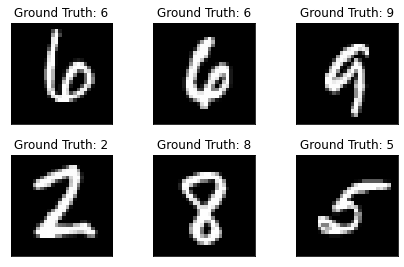

In [5]:
fig = plt.figure()

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
 


In [6]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [39]:
network = Net()
LR = 0.05 
MOMENTUM = 0.5
optimizer = torch.optim.SGD(network.parameters(), lr=LR, momentum=MOMENTUM)
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.functional.nll_loss()

In [27]:
n_epochs = 3
log_interval = 1000
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)]

In [22]:
trainloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [37]:
def train(model=network, train_loader=trainloader, num_epochs = 1, gradient_accumulation_steps = 4):
    
    # Training the model
    model.train()
    for epoch in range(num_epochs):
        
        for steps, (image, labels) in enumerate(train_loader):
            optimizer.zero_grad()

#             images = Variable(image.view(-1, 28*28))
#             labels = Variable(labels)
            

            #################  Start your code ################################
            
            output = model(image)                                  # 1.forward pass
            #loss = torch.nn.functional.nll_loss(output, labels)    # 2. compute loss function
            loss = criterion(output, labels)
            loss.backward()                                        # 3. Backward pass
            optimizer.step()                                       # 4. Optimizer step
            
            if steps % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format( \
                    num_epochs, steps * len(image), len(trainloader.dataset), \
                    100. * steps / len(trainloader), loss.item())) 
            
      
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format( \
                num_epochs, steps * len(image), len(trainloader.dataset), \
                100. * steps / len(trainloader), loss.item()))          
            #################  End your code ################################
            
    return model

In [38]:
train()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316047
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.279748
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.474514
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.052040
Train Epoch: 1 [59984/60000 (100%)]	Loss: 0.006727


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [40]:
def train2(model=network, train_loader=trainloader, num_epochs = 1, gradient_accumulation_steps = 4):
    model.train()
    optimizer.zero_grad()
    for epoch in range(num_epochs):
        
        for steps, (image, labels) in enumerate(train_loader):
            # model.train()
#             images = Variable(image.view(-1, 28*28))
#             labels = Variable(labels)
            
            #################  Start your code ################################
            
            output = model(image)                                  # 1. forward pass
            # loss = torch.nn.functional.nll_loss(output, labels)    # 2. compute loss function
            loss = criterion(output, labels)
            loss = loss/gradient_accumulation_steps                # 3. normalize loss
            loss.backward()                                        # 4. Backward pass
            
            if steps % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format( \
                    num_epochs, steps * len(image), len(trainloader.dataset), \
                    100. * steps / len(trainloader), loss.item())) 
            
            if (steps + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()         
                
            #################  End your code ################################
            
    return model

In [41]:
train2()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.570432
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.040131
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.113665
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.049735


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)